# 합성곱 신경망(CNN: Convolutional Neural Network)

* 신경네트워크(Neural Network)의 한 종류
* 사람의 시신경 구조를 모방한 구조, 인접하는 계층의 모든 뉴런과 결합된 완전연결을 구현한 아핀 계층을 사용하여 모든 입력 데이터들을 동등한 뉴런으로 처리한다.
* CNN에서 특징을 추출하는 과정은 합성곱 계층(Convolution Layer)과 풀링 계층(Pooling Layer)로 나눠지는데, 입력된 데이터를 필터가 순회하며 합성곱을 계산한 뒤 특징지도(Feature Map, 피처맵)를 생성한다.

## TPU연결 및 초기화

In [1]:
import tensorflow as tf
# TPU 연결 및 초기화
try:
    # TPUClusterResolver를 사용하여 TPU를 감지한 후 객체 생성
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    # 찾은 TPU 클러스터에 연결
    tf.config.experimental_connect_to_cluster(tpu)
    # TPU 시스템 초기화
    tf.tpu.experimental.initialize_tpu_system(tpu)
    # TPU를 사용한 분산 연산 설정
    strategy = tf.distribute.TPUStrategy(tpu)
    # TPU가 실행중임을 출력
    print('Running on TPU:', tpu.master())
except ValueError:
    # TPU가 없으면 기본 분산 전략 사용
    strategy = tf.distribute.get_strategy()
    print('Running on CPU or GPU')
# 분산 연산을 수행 중인 사용 중인 복제본(replicas)을 출력 
print('Number of replicas:', strategy.num_replicas_in_sync)

Running on CPU or GPU
Number of replicas: 1


## 모델링 전 파일 수정

### cat-vs-dog.zip 파일 압축 해제

In [4]:
import os

# 압축파일의 위치, 파일의 경로를 나누지 않고 하나로 함쳐도 상관없다
drive_path = '/Users/chunc/Desktop/'
source_dir = 'Bootcamp/python/python/ML_DL/'

# drive에 파일이 제대로 업로드되어 인식 되는지 확인
# 'cat-vs-dog.zip' 파일이 위치한 경로내 파일 목록을 리스트로 만들어 그 안에 'cat-vs-dog.zip'이 존재하는지 확인
if 'cat-vs-dog.zip' in os.listdir(drive_path + source_dir):
    print('file ready')
else:
    print('file error')

file ready


In [5]:
import shutil

source_filename = drive_path + source_dir + 'cat-vs-dog.zip'

# 저장할 경로
# 현재 경로 내 dateset 폴더를 생성하여 저장
extract_folder = 'dataset/'

# 압축 해제
shutil.unpack_archive(source_filename, extract_folder)

In [6]:
# 압축이 제대로 해제되어 'cat'과 'dog'이 정상적으로 존재하는지 확인
os.listdir(os.getcwd() + '/' + extract_folder)

['cat', 'dog']

### 파일 이름 수정

In [7]:
# 사용이 용이하도록 파일 이름 수정
import pathlib

# 사용자 함수 작성
# params: folder(dataset 폴더 내 이미지가 존재하는 폴더 이름), prefix(변경하고자 하는 파일 명)
def rename_files(folder, prefix):
    # './dataset/cat' './dataset/dog' 의 경로를 변수 path에 할당
    path = pathlib.Path(f'dataset/{folder}')
    # path 내 존재하는 파일 목록을 리스트화
    files = os.listdir(path)
    # 파일 이름에 포함시킬 인덱스 초기화
    index = 0
    
    # cat, dog 폴더 내 존재하는 이미지를 하나씩 반복
    for file in files:
        if file.endswith('.jpg'):
            new_name = f'{prefix}_{index}.jpg'
            os.rename(os.path.join(path, file), os.path.join(path, new_name))
            index += 1
# 사용자 함수 실행
rename_files('cat', 'cat')
rename_files('dog', 'dog')

### 이미지 파일을 훈련/검증/테스트 디렉토리로 복사

In [8]:
# 원래 디렉토리
original_dir = pathlib.Path('dataset')
# 새롭게 옮길 디렉토리
new_base_dir = pathlib.Path('cats_vs_dogs_small')

def make_subset(subset_name, start_index, end_index):
    for category in ('cat', 'dog'):
        
        # 원본 데이터셋에서 각 카테고리 폴더의 경로 (이따가 '/'+로 시도해보기)
        original_category_dir = original_dir / category
        # 새로운 서브셍의 디렉토리 생성 (ex. cats_vs_dogs_small/train/cat)
        new_subset_dir = new_base_dir / subset_name / category
        # 새로운 서브셋 디렉토리 생성
        os.makedirs(new_subset_dir)
        # 복사할 파일 이름 목록 생성
        fnames = [f'{category}_{i}.jpg' for i in range(start_index, end_index)]
        for fname in fnames:
            # 파일 복사
            shutil.copyfile(src = original_category_dir / fname,    # 원본 파일 경로
                           dst = new_subset_dir / fname)   # 대상 파일 경로

# index 0에서 699까지는 train
make_subset('train', start_index = 0, end_index = 700)
# 700에서 799까지는 validation
make_subset('validation', start_index = 700, end_index = 800)
# 800에서 999까지는 tes
make_subset('test', start_index = 800, end_index = 1000)

## 모델 생성

### Convnet layer의 특성
* Dense layer를 바탕으로 전역 패턴을 학습하는 ANN과 달리 Convnet layer는 지역 패턴을 학습
* 학습된 패턴은 이동불변성(translation invatiant)을 지닌다.<br>
: 어느 한 지역에서 인식한 패턴은 다른 지역에서도 인식 가능 <br>
    (ex) 좌하단에서 학습한 패턴이 우상단에도 존대하는 경우 같은 패턴으로 인식<br>
    
    - Dense layer는 같은 패턴이라도 위치가 다르면 다른 패턴으로 인식
    - 학습 속도 증가, 적은 샘플로도 학습이 가능
* Convnet은 인간의 시각 인식과 유사하게 패턴의 공간적 계층구조를 학습 가능 <br>
: 동그라미, 곡선 > 동공, 흰자위 > 눈을 인식하듯이 다음 convnet layer는 이전 convnet layer의 특성으로 구성된 더 큰 패턴을 학습

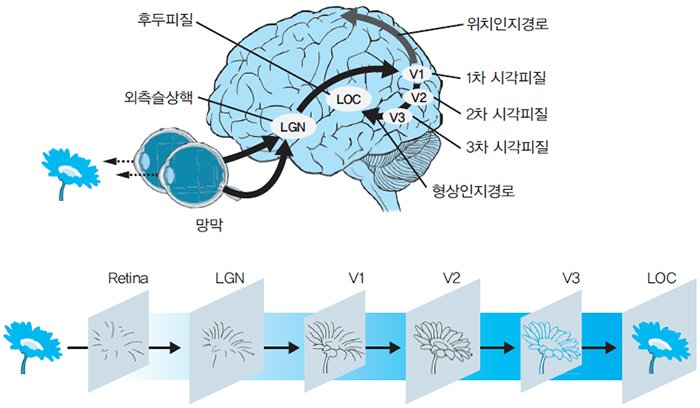

* 합성곱 네트워크

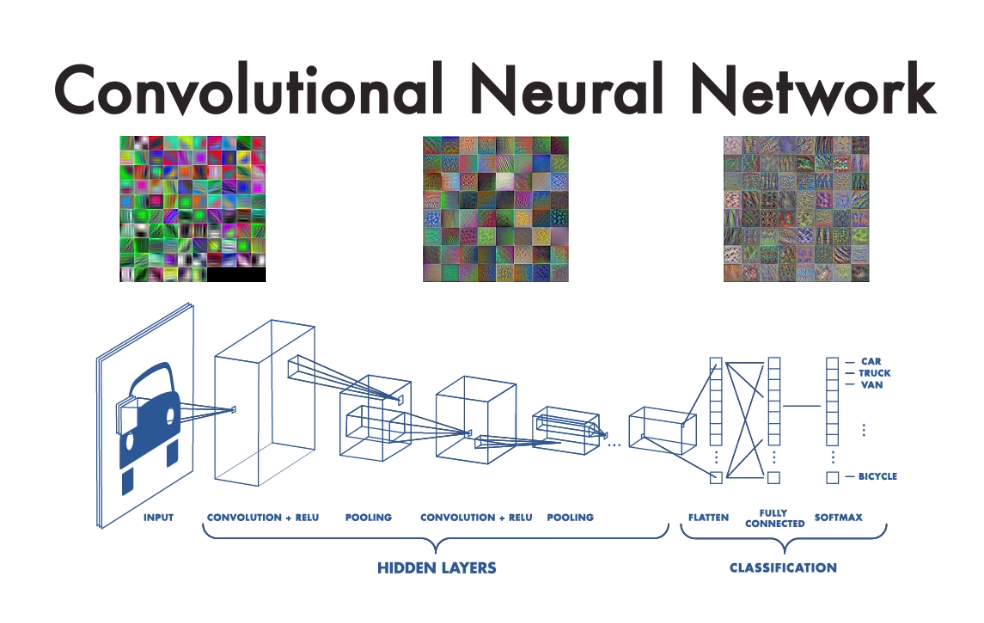

* 높이x너비x깊이(패널)의 3D 텐서인 특성맵(feature map)을 input data로 사용
    - 보통 이미지의 가로 길이 x 세로 길이 x 채널로 구성
    - 흑백 이미지의 경우 1벡터, 컬러 이미지의 경우 3벡터(RGB), 투명도가 들어가는 경우 4벡터(RGB + 투명도)

* 합성곱 연산(Convolution)과 서브샘플링(Pooling)을 반복하며 해당 이미지 지역에 대한 특성 추출하고, 지역패턴들을 합성
* 합성곱 연산

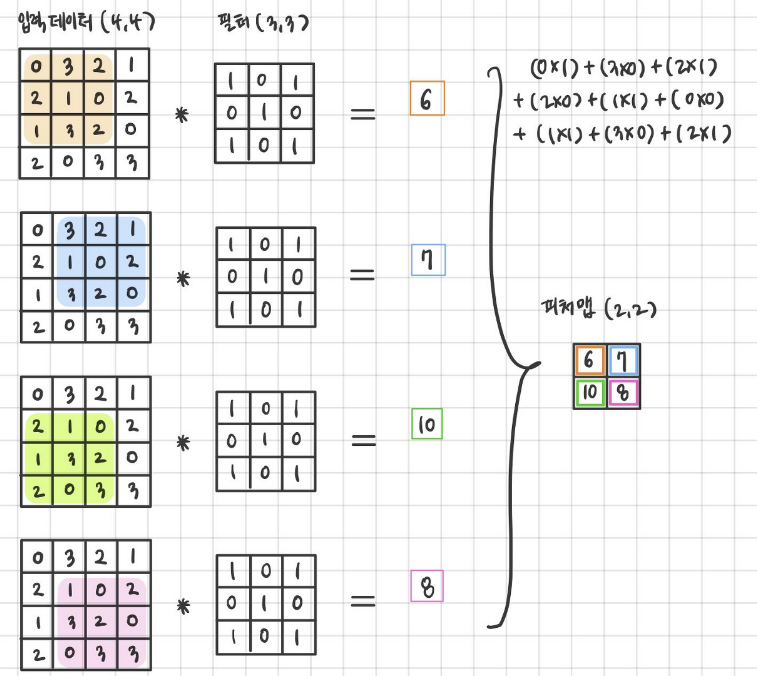

* 3x3 안에 들어가는 숫자는 일반적으로 랜덤한 값을 가지는 가중치이다(weight)
* 학습 과정에서 업데이트되어 최적화
* 일반적으로 손실 함수(loss function)를 최소화 하기 위한 가중치 조정은 경사하강법(gradient descent) 알고리즘을 사용한다.

### 필터(Filter)
* 이미지 특징을 찾기 위한 정사각형 행렬로 정의된 파라미터, 커널(Kernel)로도 불린다.

### 스트라이드(Stride)
* 합성곱 연산과 풀링 연산 시 필터의 슬라이딩 간격(필터를 적용하는 위치간격을 의미함)
* 스트라이드가 커지면 필터의 윈도우가 적용되는 간격이 넓어져 출력 데이터의 크기가 줄어든다.

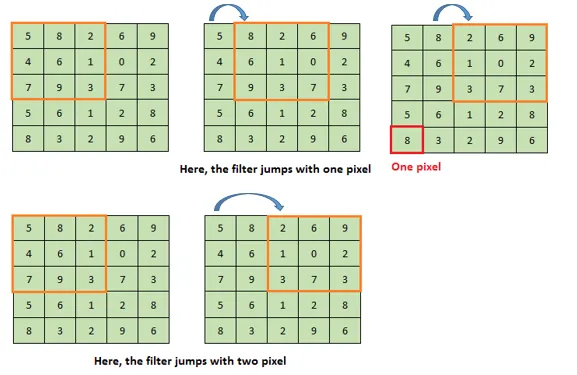

* 위의 예시가 1스트라이드 슬라이딩, 아래 예시가 2스트레이드 슬라이딩이다.
- 합성곱 연산으로 줄어드는 이미지 크기
$$output={{N-F} \over {S}}+1$$
$$N=입력\;데이터\;크기,\;F=필터\;크기,\;S=스트라이드$$
    - (ex) 5x5 이미지가 1스트리이드 3x3 필터를 사용해 합성곱 연산을 거칠 경우 출력값은 3x3이 됨

- 풀링 필터 스트라이드 
    - 합성곱 필터 슬라이딩과 다르게 다음 필터와 겹치지 않게 슬라이딩

### 풀링(Pooling)
* 독립적인 채널별 연산. 입력데이터의 채널 수가 변화되지 않도록 2차원 데이터의 세로 및 가로 방향의 공간을 줄이는 연산
* 맥스 풀링: 필터 내에서 최대값을 가진 픽셀을 풀링(가장 많이 사용)
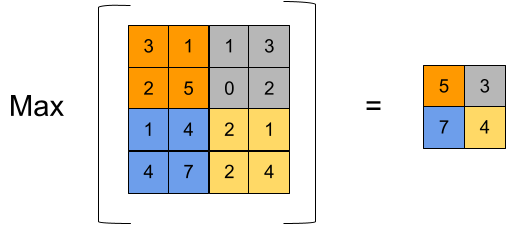
* 평균 풀링: 필터 내 픽셀들의 평균값을 풀링
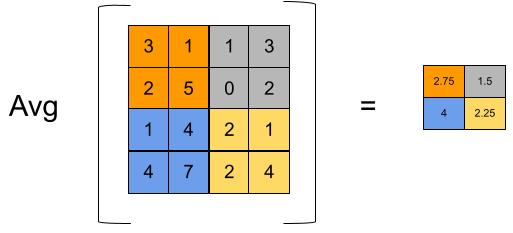

### 패딩
* 합성곱 연산을 반복수행 시 출력크기가 1이되어 더 이상 연산을 진행하기 어려운 상태를 사전 예방하기 위한 조치로 출력크기를 조절하는 기법
* 연산 전에 입력데이터의 주위를 0 또는 1로 채워 출력 데이터의 크기를 입력 데이터의 크기와 동일하게 설정
* 합성곱 연산 이후 이미지 크기가 줄어들지 않도록 추가하는 테두리
* 주로 0을 채우며, 이 경우엔 zero-padding 이라고 한다.
* 합성곱, 풀링 모두 텐서 크기를 감소시키기에 원본 데이터의 크기가 충분히 크지 않은 경우 충분한 학습이 가능할 만큼의 Convnet layer 층을 생성 못할 수 있다 -> 이를 해결하기 위하여 패딩 적용

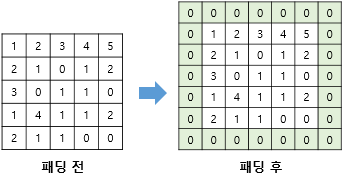

* 입력 데이터에 대한 필터의 크기와 스트라이드(Stride) 크기에 따라서 특징지도 크기가 결정된다.

### 강아지 vs. 고양이 분류를 위한 소규모 CNN 만들기

In [9]:
from tensorflow import keras
from keras import layers

# 함수형 API를 사용한 레이어 설정
# 이미지 데이터를 입력으로 할 것이므로 shape은 (이미지 높이, 이미지 너비, 채널 수)로 지정 
# (채널의 경우컬러는 3, 흑백은 1)
inputs = keras.Input(shape = (180, 180, 3))
# 이미지 데이터 스케일링(이미지 데이터의 픽셀 값은 일반적으로 0에서 255까지의 범위, 1.은 소수점 이하가 0)
x = layers.Rescaling(1. / 255)(inputs)

x = layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu')(x)
# filters: 입력 데이터 필터링(일반적으로 적당한 값이 32, 64, 128, 256, ...) 값이 커지면 더 복잡한 패턴 학습, 개수가 너무 많아지면 과적합 발생
# kernel_size: 합성곱에서 필터의 크기를 조정, 일반적으로 3x3, 5x5, 7x7
# kernel_size가 작을수록 필터가 작아지고, 많은 수의 작은 필터를 적용하는 것이 하나의 큰 필터를 적용하는 것보다 더 성능이 좋을 수 있다
# 다만 kernel_size가 작아지면 연산량이 많아져서 모델의 학습 속도가 느려진다

# 일정크기로 다운샘플링, 필터크기를 2x2(pool_size = 2)로 지정
x = layers.MaxPooling2D(pool_size = 2)(x)

x = layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)

x = layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)

x = layers.Conv2D(filters = 256, kernel_size = 3, activation = 'relu')(x)
x = layers.MaxPooling2D(pool_size = 2)(x)

x = layers.Conv2D(filters = 256, kernel_size = 3, activation = 'relu')(x)
# 이전 층에서 나온 다차원 벡터 결과물 x를 1차원 벡터로 평탄화(flattening) -> Dense layer에 전달하기 위해 수행
x = layers.Flatten()(x)

# 출력 레이어: 유닛 개수 = 1, 활성화함수 = 시그모이드 함수
# 모델 생성
outputs = layers.Dense(1, activation = 'sigmoid')(x)
model = keras.Model(inputs = inputs, outputs = outputs)

* **Layer(type)**: 레이어의 이름과 타입을 나타낸다. 알아서 레이어의 이름을 지정해주므로 따로 지정하고 싶을때는 'name="지정하고 싶은 이름"'으로 설정하면 된다.
* **Output Shape**: None개의 행과 아웃풋의 값이 주어지는 것을 말한다. 행이 None으로 지정되는 이유는 데이터의 갯수는 계속해서 추가될 수 있기 때문에 딥러닝 모델에서는 주로 행을 무시하고 열의 shape을 맞추어주는 작업을 많이 수행합니다
* **Param**: 파라미터의 수, 입력노드와 출력노드에 대해 연결된 간선의 수를 뜻한다. 인풋에 bias노드가 추가되기 때문에 파라미터의 개수가  [(7 * 7 * 256) * 1] + 1, 즉 12545가 되는 것이다.

In [10]:
# 모델 생성 결과 요약
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [11]:
# 모델 컴파일
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

## 데이터 전처리

### 학습/검증/평가 데이터셋 생성

In [12]:
import pathlib
from keras.utils import image_dataset_from_directory
# 주어진 디렉토리에서 이미지 데이터셋을 생성하는 image_dataset_from_directory 메소드 import
# 디렉토리 구조를 기반으로 자동으로 클래스 결정
# ex. /train/cat/cat_109.jpg 는 하위 폴더인 cat으로 라벨링됨

new_base_dir = pathlib.Path('cats_vs_dogs_small')

# 학습 데이터셋 생성
train_dataset = image_dataset_from_directory(new_base_dir / 'train',        # 경로
                                            image_size = (180, 180),        # 이미지 사이즈
                                            batch_size = 32)                     # 학습 배치 사이즈

# 검증 데이터셋 생성
validation_dataset = image_dataset_from_directory(new_base_dir / 'validation',
                                                 image_size = (180, 180),
                                                 batch_size = 32)

# 평가 데이터셋 생성
test_dataset = image_dataset_from_directory(new_base_dir / 'test', image_size = (180, 180), batch_size = 32)

Found 1400 files belonging to 2 classes.
Found 200 files belonging to 2 classes.
Found 400 files belonging to 2 classes.


### 텐서플로우 Dataset 객체 이해하기

In [13]:
import numpy as np
import tensorflow as tf
# 정규분포에서 무작위 추출을 통해 2차원 텐서(1000x16) 생성
random_numbers = np.random.normal(size = (1000, 16))

dataset = tf.data.Dataset.from_tensor_slices(random_numbers)
# tf.data.Dataset 객체를 생성하려면, from_tensor_slices() 메소드를 사용하여 위에서 생성한 2차원 텐서를 입력으로 전달
# (텐서를 분할하여 각 요소를 하나의 데이터 포인트로 간주하는 데이터셋 생성)

In [14]:
# dataset 객체에서 처음 세 개(0, 1, 2번)의 데이터 요소의 형태(shape)를 출력
# 크기 16의 벡터 형태임을 확인 가능
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [15]:
# 1,000개의 벡터를 32개씩 배치화
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [16]:
# 크기 16의 벡터를 4x4 크기의 2D 텐서로 변환
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


### 개와 고양이 사진의 데이터와 레이블 크기 확인

In [18]:
# 개/고양이 그림 train_dataset에서 data_batch와 labels_batch의 형태 확인
for data_batch, labels_batch in train_dataset:
    print('데이터 배치 크기: ', data_batch.shape)
    print('레이블 배치 크기: ', labels_batch.shape)
    break

데이터 배치 크기:  (32, 180, 180, 3)
레이블 배치 크기:  (32,)


## 모델 학습

### 사용자 콜백 정의 및 모델 학습

In [19]:
# 사용자 callbaxk 정의
callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = 'convnet_from_scratch.keras', save_best_only = True, monitor = 'val_loss')
]
# filepath: 저장할 모델의 파일 경로
# save_best_only: True로 설정하면, 가장 낮은 검증 손실을 가진 모델만 저장
# monitor: 모델 저장 여부를 결정하는 기준(여기서는 검증 손실을 기준으로 저장)

# 모델 학습
history = model.fit(
train_dataset, epochs = 30, validation_data = validation_dataset, callbacks = callbacks)
# train_dataset: 학습에 사용할 데이터셋을 지정
# epochs: 전체 데이터셋에 대한 학습 반복 횟수 지정
# validation_data: 모델의 성능을 평가할 검증 데이터셋 지정
# callbacks: 사용자 정의 콜백 지정
# 가장 낮은 검증 손실을 가진 모델이 "convnet_from_scratch.keras" 파일로 저장

Epoch 1/30
44/44 [==============================] - 33s 728ms/step - loss: 0.7231 - accuracy: 0.4936 - val_loss: 0.6920 - val_accuracy: 0.5100
Epoch 2/30
44/44 [==============================] - 30s 688ms/step - loss: 0.6977 - accuracy: 0.5186 - val_loss: 0.7025 - val_accuracy: 0.5000
Epoch 3/30
44/44 [==============================] - 30s 670ms/step - loss: 0.6986 - accuracy: 0.5657 - val_loss: 0.6830 - val_accuracy: 0.5300
Epoch 4/30
44/44 [==============================] - 30s 685ms/step - loss: 0.6864 - accuracy: 0.5329 - val_loss: 0.9352 - val_accuracy: 0.5150
Epoch 5/30
44/44 [==============================] - 31s 691ms/step - loss: 0.6587 - accuracy: 0.6114 - val_loss: 0.7703 - val_accuracy: 0.5250
Epoch 6/30
44/44 [==============================] - 29s 665ms/step - loss: 0.6305 - accuracy: 0.6521 - val_loss: 0.9874 - val_accuracy: 0.5200
Epoch 7/30
44/44 [==============================] - 30s 680ms/step - loss: 0.6042 - accuracy: 0.6829 - val_loss: 0.6254 - val_accuracy: 0.6650

### 정확도와 손실 그래프 작성

* 그래프의 마커 참고: https://matplotlib.org/stable/api/markers_api.html

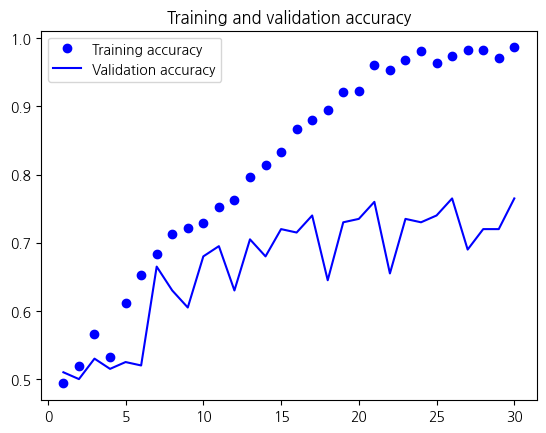

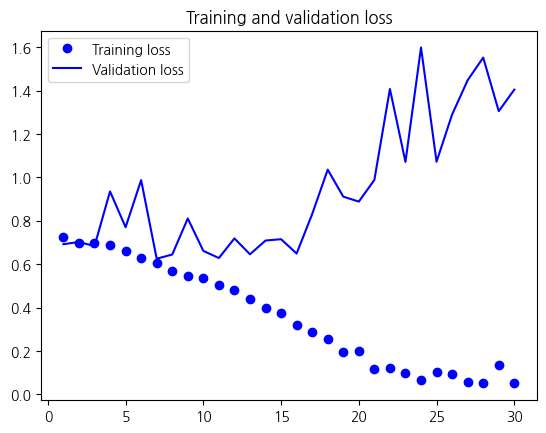

In [20]:
import matplotlib.pyplot as plt

# history.history를 이용하여 학습동안 기록된 정확도와 손실값을 변수에 할당
# 학습 정확도를 accuracy 변수에 할당
accuracy = history.history['accuracy']
# 검증 정확도를 val_accuracy 변수에 할당
val_accuracy = history.history['val_accuracy']
# 학습 손실을 loss 변수에 할당
loss = history.history['loss']
# 검증 손실을 val_liss 변수에 할당
val_loss = history.history['val_loss']

# epoch 수만큼 범위 지정 (range는 n-1까지만 범위로 설정하므로 +1)
epochs = range(1, len(accuracy) + 1)

# 정확도 시각화
# 학습 정확도를 파란색 원으로 표시, (x = epochs, y = accuracy, 'bo' = 파란색 점)
plt.plot(epochs, accuracy, 'bo', label = 'Training accuracy')
# 검증 정확도를 파란색 선으로 표시, (x = epochs, y = val_accuracy, "b"=파란색 선)
plt.plot(epochs, val_accuracy, 'b', label = 'Validation accuracy')
# 그래프 제목 설정
plt.title('Training and validation accuracy')
# 그래프 범례 표시
plt.legend()

# 손실 시각화
# 새로운 figure 생성 (손실 그래프 표시를 위해)
plt.figure()
# 학습 손실을 파란색 원으로 표시
plt.plot(epochs, loss, 'bo', label = 'Training loss')
# 검증 손실을 팔나색 선으로 표시
plt.plot(epochs, val_loss, 'b', label = 'Validation loss')
plt.title("Training and validation loss")
plt.legend()
# 그래프 출력
plt.show()

## 모델 평가

### 테스트 데이터 세트로 모델 평가하기

In [22]:
# 콜백에서 저장한 best 모델로 모델 생성
test_model = keras.models.load_model('convnet_from_scratch.keras')

# 테스트 데이터셋으로 평가 후 평가 손실(test_loss), 평가 정확도(test_acc) 변수 생성
test_loss, test_acc = test_model.evaluate(test_dataset)

# 결과 출력
print(f'테스트 정확도: {test_acc:.3f}')

13/13 [==============================] - 2s 154ms/step - loss: 0.6576 - accuracy: 0.6200
테스트 정확도: 0.620


## 데이터 증식

* 위 그래프를 보면 과대 적합이 발생한 것을 알 수 있다.
    - 학습 정확도는 반복수에 따라 지속적으로 끝없이 상승하는 반면, 검증 정확도는 0.7가량에서 정체됨
    - 학습 손실은 지속적으로 감소하였지만 검증 손실은 5epoch만에 감소가 끝남
* 과대 적합을 해소하기 위해서 다음의 방법들을 사용한다.
    - 규제
    - 드롭아웃
    - 데이터 증식
* 이중 데이터 증식은 이미지 비전에 특화되어 많이 사용된다.
    - 이미지의 다양성을 늘려서 같은 이미지를 2번 보기 힘들게 만들어 과적합을 방지할 수 있다.

### Convnet에 추가할 데이터 증식 단계 정의

In [23]:
# sequential 모델을 사용하여 데이터 증식 레이어 정의
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip('horizontal'),    # 무작위로 이미지를 수평으로 뒤집는 레이어
        layers.RandomRotation(0.1),        # 무작위로 이미지를 회전하는 레이어: 회전범위는 0.1라디안(약 5.73도)
        layers.RandomZoom(0.2),           # 무작위로 이미지를 확대/축소하는 레이어: 확대/축소 범위는 0.2로, 20%까지 이미지를 확대하거나 축소
    ]
)

### 랜덤하게 증식된 학습 이미지 출력

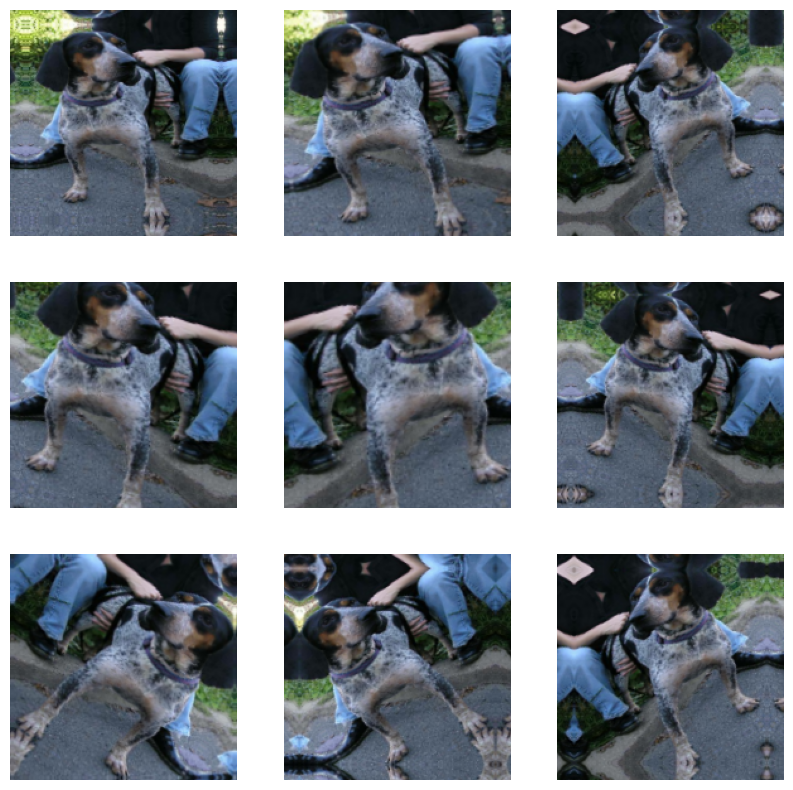

In [24]:
# 새로운 figure 생성
plt.figure(figsize = (10, 10))
# train_dataset에서 하나의 batch를 가져와 images와 _(라벨은 사용하지 않으므로 _로 표시) 변수에 할당
# 이미지별 반복
for images, _ in train_dataset.take(1):
    # 9개의 이미지를 시각화하기 위한 반복
    for i in range(9):
        # 상기 정의한 데이터 증식 레이어를 사용하여 이미지를 증식하고, 그 결과를 augmented_images 변수에 할당
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        # 증식된 이미지의 dtype을 unit8로 변환 후 출력
        plt.imshow(augmented_images[0].numpy().astype('uint8'))
        plt.axis('off')

### 이미지 증식과 드롭아웃을 포함한 Convnet생성

* **드롭아웃**: 은닉층의 뉴런을 임의로 삭제하면서 학습하는 방법, 적은 뉴런만으로 훈련한 뒤 테스트 시에 전체 뉴런을 사용하면 정답을 보다 잘 찾을 수 있게 된다. 

In [26]:
# 레이어 생성
# 입력 레이어
inputs = keras.Input(shape = (180, 180, 3))
# 데이터 증식 레이어
x = data_augmentation(inputs)
# 데이터 스케일링 레이어
x = layers.Rescaling(1. / 255)(x)

# Convnet layer1
x = layers.Conv2D(filters = 32, kernel_size = 3, activation = 'relu')(x)
# subsampling layer 1
x = layers.MaxPooling2D(pool_size = 2)(x)

# Convnet layer2
x = layers.Conv2D(filters = 64, kernel_size = 3, activation = 'relu')(x)
# subsampling layer 2
x = layers.MaxPooling2D(pool_size = 2)(x)

# Convnet layer3
x = layers.Conv2D(filters = 128, kernel_size = 3, activation = 'relu')(x)
# subsampling layer 3
x = layers.MaxPooling2D(pool_size = 2)(x)

# Convnet layer4
x = layers.Conv2D(filters = 256, kernel_size = 3, activation = 'relu')(x)
# subsampling layer 4
x = layers.MaxPooling2D(pool_size = 2)(x)

# Convnet layer5
x = layers.Conv2D(filters = 256, kernel_size = 3, activation = 'relu')(x)
# 평탄화 레이어
x = layers.Flatten()(x)

# 드롭아웃 레이어: 해당 layer를 거칠 시 뉴런 50% 비활성화(과적합 발생 가능성이 높은 경우)
x = layers.Dropout(0.5)(x)

# 출력 레이어
outputs = layers.Dense(1, activation = 'sigmoid')(x)
# 모델 재생성
model = keras.Model(inputs = inputs, outputs = outputs)

In [27]:
# 모델 컴파일
model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])

### 사용자 증식 Convnet 학습하기

In [28]:
# 사용자 정의 콜백 작성
callbacks = [keras.callbacks.ModelCheckpoint(filepath = 'convnet_from_scratch_with_augmentation.keras',
                                            save_best_only = True, monitor = 'val_loss')]

# 모델 학습
history = model.fit(train_dataset, epochs = 100, validation_data = validation_dataset, callbacks = callbacks)

Epoch 1/100
44/44 [==============================] - 35s 763ms/step - loss: 0.6981 - accuracy: 0.4993 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 2/100
44/44 [==============================] - 33s 739ms/step - loss: 0.6937 - accuracy: 0.5271 - val_loss: 0.6913 - val_accuracy: 0.5700
Epoch 3/100
44/44 [==============================] - 31s 698ms/step - loss: 0.6955 - accuracy: 0.5557 - val_loss: 0.6886 - val_accuracy: 0.5350
Epoch 4/100
44/44 [==============================] - 32s 723ms/step - loss: 0.6896 - accuracy: 0.5371 - val_loss: 0.6621 - val_accuracy: 0.5950
Epoch 5/100
44/44 [==============================] - 33s 744ms/step - loss: 0.6873 - accuracy: 0.5743 - val_loss: 0.6498 - val_accuracy: 0.6500
Epoch 6/100
44/44 [==============================] - 31s 706ms/step - loss: 0.6496 - accuracy: 0.6364 - val_loss: 0.6621 - val_accuracy: 0.5850
Epoch 7/100
44/44 [==============================] - 33s 758ms/step - loss: 0.6274 - accuracy: 0.6593 - val_loss: 0.6825 - val_accuracy:

### 테스트 데이터 세트로 데이터 증식 모델 평가

In [29]:
test_model = keras.models.load_model('convnet_from_scratch_with_augmentation.keras')
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f'테스트 정확도: {test_acc:.3f}')

13/13 [==============================] - 2s 162ms/step - loss: 0.5943 - accuracy: 0.7200
테스트 정확도: 0.720
